# Open Hydrology - Flood Estimation

This notebook was created to capture the data wrangling process for all the datasets. This will include the commands used in NCO and other libraries, but it will only run code written in Python.

---

#### Author: 
                Luis F Patino Velasquez - NU

#### Date:
                Feb 2022

#### Version:
                1.0

#### Notes:
                - To get jupyter env version type `!jupyter --version` in a python cell
            
#### Jupyter version:
                jupyter core     : 4.6.3
                jupyter-notebook : 6.4.8
                qtconsole        : 5.2.2
                ipython          : 7.18.1
                ipykernel        : 5.3.4
                jupyter client   : 6.1.7
                nbconvert        : 6.4.1
                ipywidgets       : 7.6.5
                nbformat         : 5.1.3
                traitlets        : 5.0.5

#### Python version:
                3.8.5 

---

## Main considerations

* This script uses the [NRFA API](https://nrfaapps.ceh.ac.uk/nrfa/nrfa-api.html#ws-station-info) to retrieved the data necessary for the analysis

## Setting Python Modules

In [22]:
# Data handling
import pandas as pd
import numpy as np
# import lmoments3 as lm
from scipy.stats import moment, kurtosis, skew, genextreme as gev, gamma
from scipy.stats import genextreme as gev


# Data fetching
import urllib3
from urllib3 import request
import json
import certifi # to handle certificate verification - just to make sure it is a safe site

# # Notebook interaction
from IPython.display import display, clear_output
from ipywidgets import widgets, Dropdown, Layout

# Data visualisations
from matplotlib import pyplot as plt


### Global variables

In [3]:
# The base URL to access the NFRA API
base_url = "https://nrfaapps.ceh.ac.uk/nrfa/ws"
base_url_timeseries = "https://nrfaapps.ceh.ac.uk/nrfa/ws/time-series"
# for all available formats - as NFRA API documentation
response = "format=json-object"

### Functions

In [4]:
############################################################
# Create dataframe in the right format
############################################################
def create_df(df_api):
    """This takes the JSON normalised dataframe and create 
    a dataframe with two column, one for the date and one for
    values

    Args:
        df_api (object): JSON normalized panda dataframe

    Returns:
        object: dataframe containing the NRFA API data
    """
    # Adding column name
    df_api.columns = ['data']
    
    # The data comes all together so needs splitting
    # even rows - dates / odd rows - data values
    df_even = df_api.iloc[:-2:2]
    lst_even = list(df_even['data']) # column to list 
    df_odd = df_api.iloc[1:-2:2]
    lst_odd = list(df_odd['data']) # column to list 
    
    # Create dataframe with the available data
    zipped = list(zip(lst_even, lst_odd))
    df_fixed = pd.DataFrame(zipped, columns=['Date', 'value'])
    
    return df_fixed
    
def fetch_station_data(url_to_fetch):
    """Fetch data using NRFA API

    Args:
        url_to_fetch (string): url part containing the information
        to be requested

    Returns:
        object: dataframe containing the NRFA API data
    """
    # Get data from the API
    station_data_url = f"{base_url_timeseries}/" + f"?{response}" + f"&{url_to_fetch}"
    r = http.request('GET', station_data_url)
    r.status

    # Decode json data into a dict object
    data = json.loads(r.data.decode('utf-8'))
    
    # In this dataset, the data to extract is under 'station-ids'
    df = pd.DataFrame() # always start with an empty dataframe
    df = pd.json_normalize(data, 'data-stream') # this can be a parameter to parse
    
    # Check if station has any data for the variable of interest
    # If not data then create dataframe fill with zeros
    if df.empty is False:
        df_final = create_df(df)
    else:
        df_final = pd.DataFrame(0, index=np.arange(1), columns=['Date','value'])
    
    # Add a name to the dataframe
    name_df = url_to_fetch.split('=')[1].split('&')[0]
    df_final.name = name_df
    
    return df_final

def station_id_wdg(url_to_fetch):
    """Build widget to select NRFA station id

    Args:
        url_to_fetch (string): the url parameter as per NRFA API docs
    """
    # Get data from the API
    station_ids_url = f"{base_url}/" + url_to_fetch + f"?{response}"
    r = http.request('GET', station_ids_url)
    r.status

    # Decode json data into a dict object
    data = json.loads(r.data.decode('utf-8'))

    # In this dataset, the data to extract is under 'station-ids'
    df_stationIDs = pd.json_normalize(data, 'station-ids')
    df_stationIDs.columns = ['station-ids']

    # Build the widget to be displayed
    
    stations_dropdown = widgets.Dropdown(
        options=list(df_stationIDs['station-ids']),
        value=22007,
        width='auto', 
        height='auto',
        description='Station ID:',
        disabled=False,
    )
    return stations_dropdown

def nrfa_data(b):
    """Using the station id from the dropdown
    menu. It uses the NRFA API to get the data
    in a JSON format and put it inside a pandas
    dataframe

    Args:
        id_station (int): station id from dropdown

    Returns:
        [object]: dataframe containing the API data
    """
    
    # read station id from dropdown
    nrfa_data.stn_id = station_wdg.value
    
    # add the missing part of the API url
    station_API_url_amx = f'data-type=amax-flow&station={nrfa_data.stn_id}'
    station_API_url_pot = f'data-type=pot-flow&station={nrfa_data.stn_id}'
    
    # fetch data and create dataframes
    nrfa_data.data_api_amx = fetch_station_data(station_API_url_amx)
    nrfa_data.data_api_pot = fetch_station_data(station_API_url_pot)
    
    # with output:
    #     print (f'Your data for station {stn_id} has been fetched from the NRFA API')
    #     print(nrfa_data.data_api_amx)
    
    lst_df_fetched = [nrfa_data.data_api_amx, nrfa_data.data_api_pot]

    with output:
        clear_output()
        for df_fetched in lst_df_fetched:         
            if df_fetched.shape[0] == 1:
                print('----'*4)
                print (f'No data could be found in the {df_fetched.name} for the station {nrfa_data.stn_id} in the NRFA API')
            else:
                print('----'*4)
                print (f'{df_fetched.name} data for the station {nrfa_data.stn_id} has been put into a datrame ready for analysis')
    # print (f'Your data for station {stn_id} has been fetched from the NRFA API')
    return nrfa_data.data_api_amx, nrfa_data.data_api_pot

    

---
### Test Area

In [125]:
# # https://nrfaapps.ceh.ac.uk/nrfa/ws/time-series?format=json-object&data-type=cdr&station=45001
# # https://nrfaapps.ceh.ac.uk/nrfa/ws/time-series?format=json-object?&data-type=cdr&station=45001
# station_API_url = 'station-ids'
# station_ids_url = f"{base_url}/" + station_API_url + f"?{response}"
# print(station_ids_url)

# station_API_url_v2 = 'data-type=amax-stage&station=45001'
# station_ids_url_v2 = f"{base_url_timeseries}" + f"?{response}" + f"&{station_API_url_v2}"
# print(station_ids_url_v2)

# check = fetch_station_data(station_ids_url_v2)
# check

stn_id = 1001
# add the missing part of the API url
station_API_url_amx = f'data-type=amax-stage&station={stn_id}&flag=true'
# station_API_url_gmf = f'data-type=gmf&station={stn_id}'
# station_API_url_cdr = f'data-type=gmf&station={stn_id}'
# station_API_url_cmr = f'data-type=cmr&station={stn_id}'
# fetch data and create dataframe
# nrfa_data.data_api_amx = fetch_station_data(station_API_url_amx)
# nrfa_data.data_api_gmf = fetch_station_data(station_API_url_gmf)
# nrfa_data.data_api_cdr = fetch_station_data(station_API_url_cdr)
# nrfa_data.data_api_cmr = fetch_station_data(station_API_url_cmr)


station_data_url = f"{base_url_timeseries}/" + f"?{response}" + f"&{station_API_url_amx }"
r = http.request('GET', station_data_url)
r.status

# Decode json data into a dict object
data = json.loads(r.data.decode('utf-8'))

# In this dataset, the data to extract is under 'station-ids'
df = pd.json_normalize(data, 'data-stream') # this can be a parameter to parse
# Check if station has any data for the variable of interest
if df.empty is False:
    df_final = create_df(df)
else:
    df_final = pd.DataFrame(0, index=np.arange(1), columns=['Date','value'])
# df_final = create_df(df)

name_df = station_API_url_amx.split('=')[1].split('&')[0]
print(station_API_url_amx.split('=')[1].split('&')[0])
df_final.name = name_df 

df_final.shape[0]
print(df_final.name)
    

amax-stage
amax-stage


---

### Handling Certification

In [5]:
# handle certificate verification and SSL warnings
# https://urllib3.readthedocs.io/en/latest/user-guide.html#ssl
http = urllib3.PoolManager(
       cert_reqs='CERT_REQUIRED',
       ca_certs=certifi.where())

### Build widgets
This will enable the user to fetch the data from the NRFA API

In [6]:
# Create widget for station and button to click for submission

# List of stations id widget
station_API_url = 'station-ids'
station_wdg = station_id_wdg(station_API_url)
    


# Create button widget ready to feath data
button = widgets.Button(description="Click to get data from NRFA", layout=widgets.Layout(height='50px', width='auto'), button_style="info")
output = widgets.Output() 
button.on_click(nrfa_data)

# widgets.Box(children=[station_wdg,button, output])
widgets.TwoByTwoLayout(top_right=button,
                       top_left=station_wdg,
                       bottom_left=output)




TwoByTwoLayout(children=(Dropdown(description='Station ID:', index=234, layout=Layout(grid_area='top-left'), o…

In [139]:
nrfa_data.data_api_pot

,Date,value
0,1963-03-07T00:00:00,330.000
1,1963-11-07T00:00:00,74.620
2,1963-11-10T00:00:00,101.300
3,1963-11-23T00:00:00,80.960
4,1964-03-14T00:00:00,70.030
...,...,...
162,2019-08-10T19:30:00,172.958
163,2019-10-01T12:15:00,54.511
164,2019-10-06T18:00:00,66.621
165,2019-11-05T09:45:00,71.690


---
---
## Flood estimation start here

The dataset fetched from the NRFA API has been added to pandas dataframes, here is the list of dataframe that can be called:

- nrfa_data.data_api_amx - Annual Maxima - Flow (m3/s)
- nrfa_data.data_api_pot - Peaks Over Threshold - Flow (m3/s)

### Calculate QMED
This uses the best available methodology

| method       | method options | notes                                                                                          |
|--------------|----------------|------------------------------------------------------------------------------------------------|
| amax records | n/a            | Simple median of annual maximum flow records using Catchment amax records.                     |
| pot records  | n/a            | Uses peaks-over-threshold (POT) flow records. Suitable for flow records shorter than 14 years. |


### Functions to be used in Flood estimation

In [7]:
def qmed_from_amx_records(amx_dataframe):
    """QMED calculation using annual maximum flow records (amax)

    Args:
        amx_dataframe (object): dataframe with amax records from NRFA

    Raises:
        InsufficientDataError: records in dataframe are less than 2

    Returns:
        float : QMED value
    """
    n = amx_dataframe.shape
    if n[0] < 2:
        raise InsufficientDataError(f"Insufficient annual maximum flow records available for catchment {nrfa_data.stn_id}")
    
    return amx_dataframe['value'].median()

### Outline of single-site frequency analysis
In single-site analysis only the data from the subject site are used. The recommended procedure is to treat the problem in two steps:

#### 1. QMED - Using Annual Maximum Values

In [8]:
QMED_amx = qmed_from_amx_records(nrfa_data.data_api_amx)
print('-------------------------------------')
print(f'The QMED for Station: {nrfa_data.stn_id} is: {QMED_amx}')
print('-------------------------------------')

-------------------------------------
The QMED for Station: 22007 is: 100.508
-------------------------------------


#### 2. Derivation of the growth curve
In most situations, use of a Generalised Logistic growth curve is recommended for UK flood data.

#### 2.1. Calculate L-CV and L-SKEW for a gauged catchment.

# Create column with dimensionless flows

---
---
---
# Things below are just testing work

In [ ]:
def _qmed_from_pot_records(self):
    """
    Return QMED estimate based on peaks-over-threshold (POT) records.
    Methodology source: FEH, Vol. 3, pp. 77-78
    :return: QMED in m³/s
    :rtype: float
    """
    pot_dataset = self.catchment.pot_dataset
    if not pot_dataset:
        raise InsufficientDataError("POT dataset must be set for catchment {} to estimate QMED from POT data."
                                    .format(self.catchment.id))

    complete_year_records, length = self._complete_pot_years(pot_dataset)
    
    if length < 1:
        raise InsufficientDataError("Insufficient POT flow records available for catchment {}."
                                    .format(self.catchment.id))

    position = 0.790715789 * length + 0.539684211
    i = floor(position)
    w = 1 + i - position  # This is equivalent to table 12.1!

    flows = [record.flow for record in complete_year_records]
    flows.sort(reverse=True)

    return w * flows[i - 1] + (1 - w) * flows[i]


6th moment : 
 28.69760467181203
-0.7840510728340946
0.7365011756646684
(0.023616988588586373, 118.39811413767606, 48.46195182941301)


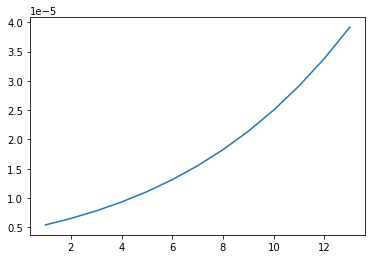

In [21]:
station_API_url_v2 = 'data-type=amax-flow&station=12008&flag=true' #12008
station_ids_url_v2 = f"{base_url_timeseries}" + f"?{response}" + f"&{station_API_url_v2}"

check = fetch_station_data(station_ids_url_v2)
check["Date"] = check["Date"].astype('datetime64[ns]')


# Moments
arr1 = [2.0, 3.0, 4.0, 2.4, 5.5, 1.2, 5.4, 2.2, 7.1, 1.3, 1.5]
print("\n6th moment : \n", moment(arr1, moment = 4))
print(kurtosis(arr1))
print(skew(arr1))


# # Filter data for specific weekday (tuesday)
# filtered_df = check.loc[check['Date'].dt.month == 10]
# filtered_df = filtered_df.sort_values(by='value', ascending=False)
# filtered_df

# print(station_ids_url_v2)

t = np.linspace(1,13,13)
fit = gev.fit(check["value"],loc=3)
pdf = gev.pdf(t, *fit)
plt.plot(t, pdf)
# plt.plot(t, check["value"], "o")
print(fit)

In [218]:
# check = check.sort_values(by='value', ascending=False)
check
# check['value'].nlargest(n=8)
# start_date = np.datetime64('1985-05-25')
# end_date = np.datetime64('2002-12-23')

# test = check.loc[(check['Date'] > start_date) & (check['Date'] < end_date)]
# test = test.loc[check['Date'].dt.year == 1993]
# test
# print(check.Date.max().year - check.Date.min().year)

,Date,value
0,1981-09-19 00:00:00,5.922
1,1981-09-26 00:00:00,5.670
2,1982-01-03 00:00:00,6.092
3,1982-06-30 00:00:00,6.007
4,1982-09-27 00:00:00,5.922
...,...,...
148,2006-06-20 16:15:00,5.645
149,2006-06-30 08:00:00,5.939
150,2006-07-09 01:45:00,5.813
151,2006-07-31 19:30:00,5.687


In [ ]:
position = 0.790715789 * check.shape[0]+ 0.539684211
i = floor(position)
w = 1 + i - position  # This is equivalent to table 12.1!

flows = [record.flow for record in complete_year_records]
flows.sort(reverse=True)

print(w * flows[i - 1] + (1 - w) * flows[i])